<a href="https://colab.research.google.com/github/hsimonfroy/diffusion-field-level/blob/main/TSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling using the TSM objective


In [1]:
!pip install --q diffrax
%pylab inline
import jax
from jax import numpy as jnp, random as jr, jit, grad, vmap, tree, value_and_grad, debug
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.9 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


## 1 Stochastic path to sample
$\newcommand{\cA}{\mathcal{A}}\newcommand{\cB}{\mathcal{B}}\newcommand{\cC}{\mathcal{C}}\newcommand{\cF}{\mathcal{F}}\newcommand{\cG}{\mathcal{G}}\newcommand{\cH}{\mathcal{H}}\newcommand{\cL}{\mathcal{L}}\newcommand{\cM}{\mathcal{M}}\newcommand{\cN}{\mathcal{N}}\newcommand{\cO}{\mathcal{O}}\newcommand{\cP}{\mathcal{P}}\newcommand{\cR}{\mathcal{R}}\newcommand{\cS}{\mathcal{S}}\newcommand{\cT}{\mathcal{T}}\newcommand{\cU}{\mathcal{U}}\newcommand{\cW}{\mathcal{W}}\newcommand{\cX}{\mathcal{X}}\newcommand{\cY}{\mathcal{Y}}\newcommand{\cZ}{\mathcal{Z}}\newcommand{\NN}{\mathbb{N}}\newcommand{\ZZ}{\mathbb{Z}}\newcommand{\QQ}{\mathbb{Q}}\newcommand{\RR}{\mathbb{R}}\newcommand{\CC}{\mathbb{C}}\newcommand{\KK}{\mathbb{K}}\newcommand{\SS}{\mathbb{S}}\newcommand{\eps}{\varepsilon}\newcommand{\ph}{\varphi}\newcommand{\pp}{\mathrm{p}}\newcommand{\qq}{\mathrm{q}}\newcommand{\HH}{\mathrm{H}}\newcommand{\PP}{\mathbb{P}}\newcommand{\EE}{\mathbb{E}}\newcommand{\OO}{\mathbb{O}}\newcommand{\Var}{\operatorname{\mathbb{V}\!ar}}\newcommand{\Cov}{\operatorname{\mathbb{C}\!ov}}\newcommand{\bs}{\boldsymbol}\newcommand{\dd}{\mathrm{d}}\newcommand{\dxdy}[2]{\frac{\dd #1}{\dd #2}}\newcommand{\pxpy}[2]{\frac{\partial #1}{\partial #2}}\newcommand{\abs}[1]{\left\lvert#1\right\rvert}\newcommand{\norm}[1]{\left\lVert#1\right\rVert}\newcommand{\T}{^\top}\newcommand{\ind}{\perp\!\!\!\perp}\newcommand{\1}{\mathbb{1}}\newcommand{\intint}[1]{\left[\!\left[#1\right]\!\right]}\newcommand{\qed}{\tag*{$\square$}}\newcommand{\lat}{x}\newcommand{\Lat}{X}\newcommand{\Ls}{\mathcal X}\newcommand{\obs}{y}\newcommand{\Obs}{Y}\newcommand{\Os}{\mathcal Y}\newcommand{\obst}{z}\newcommand{\Obst}{Z}\newcommand{\Ost}{\mathcal Z}$
* Let us have a target $x_1 \sim \pp_1$ and a stochastic Gaussian interpolation $$x_t = \alpha_t x_1 + \beta_t \eps,$$ with $\eps \sim \cN(\bs 0, I)$, scaling term $\alpha_t$, noise term $\beta_t$. We typically want $\alpha_0 = \beta_1 = 0$ and $\alpha_1 = \beta_0 = 1$. Then $$\pp_t = \alpha_t^{-1}\pp_1(\alpha_t^{-1} \cdot) * \cN(0, \beta_t^2).$$
* Let us define drift term $f_t(x) := \frac{\dot \alpha_t}{\alpha_t}x$ and diffusion term $g_t^2 := 2( \frac{\dot \alpha_t}{\alpha_t}\beta_t^2 - \beta_t \dot \beta_t ) = - \alpha_t^2 \dot{\left(\frac{\beta_t^2}{\alpha_t^2}\right)}$
* Then, the 3 following processes $(x(t))_{t}$ admits the same marginals $\forall t, x(t) = x_t \sim \pp_t$:
	* ODE $\begin{cases}\exists t_0, x(t_0) \sim x_{t_0}\\ 	\dd x = v_t(x) \dd t \quad\textrm{with}\quad v_t:= f_t+\frac{g_t^2}{2}\nabla\log\pp_t\end{cases}$
	* Backward (noising) SDE $\begin{cases}x(1) \sim x_{1}\\ 	\dd x = \left(v_t-\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd \tilde W = f_t\ \dd t + g_t\ \dd \tilde W \end{cases}$  
	  with $\tilde W$ a backward Wiener process.
	* Forward (denoising) SDE $\begin{cases}x(0) \sim x_{0}\\ 	\dd x = \left(v_t+\frac{g_t^2}{2}\nabla\log\pp_t\right)\dd t + g_t\ \dd W = \left(f_t+g_t^2\nabla\log\pp_t\right) \dd t + g_t\ \dd W\end{cases}$    
	  with $W$ a forward Wiener process.

* Noise scheduling:
	* Variance Preserving, $\beta_t^2 = 1-\alpha_t^2$, which implies $f_t(x) = \frac{\dot \alpha_t}{\alpha_t}x = \frac{g_t^2}{2}x$  
	  Typically $g_t^2 = t g_m^2 + (1-t) g_M^2$, then $\alpha_t = \exp((g_m^2(t^2-1) - g_M^2(1-t)^2)/4)$
	* Variance Exploding, $\alpha_t = 1$, which implies $f_t(x) = 0$ and $g_t^2 = -\dot{\beta_t^2} = -2\beta_t \dot \beta_t$  
	  Typically $\beta_t = \beta_m^t \beta_M^{1-t}$, then $g_t^2 = 2\beta^2 \log\left(\frac{\beta_M}{\beta_m}\right)$
	* Optimal Transport, $\alpha_t = t = 1 - \beta_t$, which implies $f_t(x) = \frac{x}{t}$, $g_t^2 = 2\left(\frac{1}{t} - 1\right)$

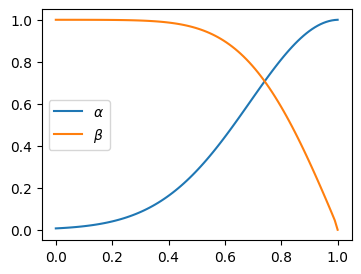

In [2]:
# Defining noise scheduling
def alpha_OT(t):
    return t

def beta_OT(t):
    return 1 - t

def alpha_VP(t, g2min=0.1, g2max=20):
    """https://huggingface.co/docs/diffusers/v0.13.0/en/api/schedulers/score_sde_vp"""
    return jnp.exp((g2min * (t**2 - 1) - g2max * (1 - t)**2) / 4)

def beta_VP(t, g2min=0.1, g2max=20.):
    alpha = alpha_VP(t, g2min, g2max)
    return (1 - alpha**2)**.5

def alpha_VE(t):
    return 1.

def beta_VE(t, betamin=0.01, betamax=100.):
    """https://huggingface.co/docs/diffusers/v0.13.0/en/api/schedulers/score_sde_ve"""
    return betamin**t * betamax**(1 - t)

# Current scheduling
alpha = alpha_VP
beta = beta_VP
drift = lambda t, y, args: grad(alpha)(t) / alpha(t) * y
diffusion = lambda t, y, args: (- alpha(t)**2 * grad(lambda t: (beta(t) / alpha(t))**2)(t))**.5 * jnp.ones_like(y)
# drift_OT = lambda t, y, args: y / t
# diffusion_OT = lambda t, y, args: (2 * (1 / t - 1))**.5 * jnp.ones_like(y)
def noise(key, t, x1):
    return alpha(t) * x1 + beta(t) * jr.normal(key, jnp.shape(x1))

tlin = jnp.linspace(0,1,100)
plt.figure(figsize=(4,3))
plt.plot(tlin, alpha(tlin), label="$\\alpha$");
plt.plot(tlin, beta(tlin), label="$\\beta$");
plt.legend();

In [71]:
def make_dist(alpha=1., beta=0., d=2, sigma0=1., probs=[0.5, 0.5]):
  """
  Returns a mixture of two d-dimensional Multivariate Gaussians.

  Args:
    d: The dimension of the Gaussian distributions.
    probs: The probabilities for the categorical distribution.
    alpha: The scaling factor for the mean of the Gaussians.
    beta: The standard deviation of the noise convolved with the Gaussians.
  """
  return tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=probs),
      components_distribution=tfd.MultivariateNormalDiag(
          loc=jnp.stack([-alpha * jnp.ones(d), alpha * jnp.ones(d)]),
          scale_diag=jnp.ones([2, d]) * ((alpha * sigma0)**2 + beta**2)**.5)
  )

def make_path(t=1, d=2, sigma0=1., probs=[0.5, 0.5]):
  """
  Returns a mixture of two d-dimensional Multivariate Gaussians.
  """
  return make_dist(alpha=alpha(t), beta=beta(t), d=d, sigma0=sigma0, probs=probs)

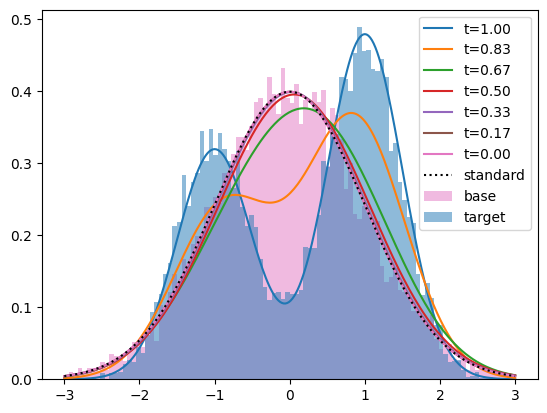

In [218]:
d = 1
sigma0 = 0.5
probs=[0.4, 0.6]
make_path = partial(make_path, d=d, sigma0=sigma0, probs=probs)
base = make_path(0.)
target = make_path(1.)
n_samples = 10000
base_samples = base.sample(n_samples, jr.key(0))
target_samples = target.sample(n_samples, jr.key(1))

xlim = (-3,3)
xlin = jnp.linspace(*xlim, 256)[...,None]
tlin = jnp.linspace(0, 1, 7)[::-1]

for t in tlin:
    dist_t = make_path(t)
    plt.plot(xlin, dist_t.prob(xlin), label=f't={t:.2f}');
plt.plot(xlin, tfd.Normal(loc=0., scale=1.).prob(xlin), ':k', label='standard');
plt.hist(base_samples, 100, range=xlim, label='base', color=f'C{len(tlin)-1}', density=True,alpha=0.5);
plt.hist(target_samples, 100, range=xlim, label='target', color='C0', density=True, alpha=0.5);
plt.legend();

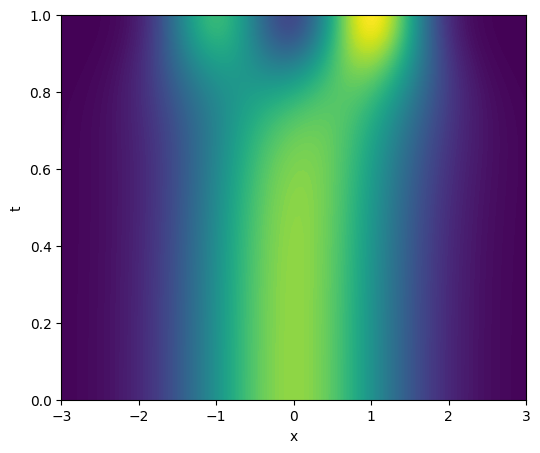

In [73]:
# We can visualize this in 2D
n_discr = 128
xx, tt = jnp.meshgrid(jnp.linspace(*xlim, n_discr), jnp.linspace(0, 1, n_discr))

# Reshape for vmap
xt = jnp.stack([tt.flatten(), xx.flatten()], axis=1)
def prob_at_tx(tx):
    t, x = tx
    dist_t = make_path(t)
    return dist_t.prob(x[...,None]).squeeze()
probabilities = vmap(prob_at_tx)(xt).reshape(n_discr, n_discr)

# Plot the contour
plt.figure(figsize=(6, 5))
plt.contourf(xx, tt, probabilities, 128)
plt.xlabel('x'), plt.ylabel('t');

Let's try to verify that our integration time is going to be rougly good enough, by running an SDE forward for time T with samples from the target distribution and verifying that we get a distribution similar to base.

In [211]:
def backward_sde(key, x1):
    eps = 1e-6
    t0, t1 = eps, 1-eps
    back_drift = lambda t, y, args: -drift(t1 - t, y, args)
    back_diffusion = lambda t, y, args: diffusion(t1 - t, y, args)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
    terms = MultiTerm(ODETerm(back_drift), ControlTerm(back_diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=1e-3, y0=x1, saveat=saveat)
    return sol.ts[::-1], sol.ys

def forward_sde(key, x0, score=lambda t, y, args: jnp.zeros_like(y)):
    eps = 1e-6
    t0, t1 = eps, 1-eps
    forw_drift = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 * score(t, y, args)
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=key)
    terms = MultiTerm(ODETerm(forw_drift), ControlTerm(diffusion, brownian_motion))
    solver = Euler()
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=1e-3, y0=x0, saveat=saveat)
    return sol.ts, sol.ys

def flow_ode(key, x0, score=lambda t, y, args: jnp.zeros_like(y)):
    eps = 1e-6
    t0, t1 = eps, 1-eps
    vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * score(t, y, args)
    terms = ODETerm(vf)
    solver = Euler()
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 100))
    sol = diffeqsolve(terms, solver, t0, t1, dt0=1e-3, y0=x0, saveat=saveat)
    return sol.ts, sol.ys

In [75]:
keys = jr.split(jr.key(0), n_samples)
ts_back, xs_back = jit(vmap(backward_sde))(keys, target_samples)

score_target = lambda t, y, args: grad(make_path(t).log_prob)(y)
forward_sde_target = jit(vmap(partial(forward_sde, score=score_target)))
ts_forw, xs_forw = forward_sde_target(keys, base_samples)

flow_ode_target = jit(vmap(partial(flow_ode, score=score_target)))
ts_flow, xs_flow = flow_ode_target(keys, base_samples)

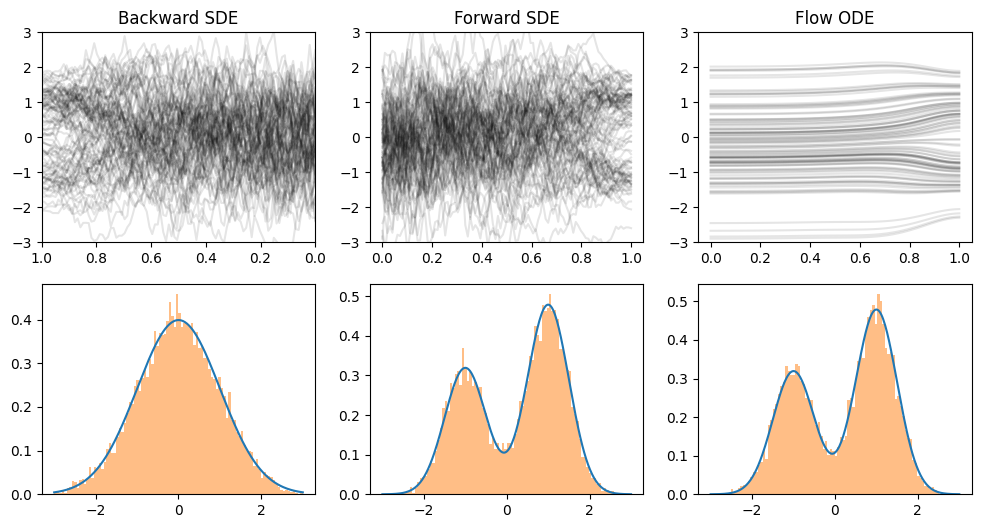

In [76]:
# Let's take a look at the trajectories
plt.figure(figsize=(12,6))
plt.subplot(231)
for i in range(100):
    plt.plot(ts_back[i], xs_back[i], 'k', alpha=0.1);
plt.ylim(xlim), plt.xlim(1.,0.)
plt.title('Backward SDE')

plt.subplot(232)
for i in range(100):
    plt.plot(ts_forw[i], xs_forw[i], 'k', alpha=0.1);
plt.ylim(xlim)
plt.title('Forward SDE')

plt.subplot(233)
for i in range(100):
    plt.plot(ts_flow[i], xs_flow[i], 'k', alpha=0.1);
plt.ylim(xlim)
plt.title('Flow ODE')

plt.subplot(234)
plt.plot(xlin, base.prob(xlin));
plt.hist(xs_back[:,-1], 100, range=xlim, density=True, alpha=0.5);

plt.subplot(235)
plt.plot(xlin, target.prob(xlin));
plt.hist(xs_forw[:,-1], 100, range=xlim, density=True, alpha=0.5);

plt.subplot(236)
plt.plot(xlin, target.prob(xlin));
plt.hist(xs_flow[:,-1], 100, range=xlim, density=True, alpha=0.5);

## 2 Score network and associated proposal probability
* Lagrangian formulation: the continuous change of variable formula along a particle trajectory yields $\dd \log \pp_t(x(t)) = - \nabla \cdot v_t(x(t)) \ \dd t$, i.e.$$\log \pp_\tau(x(\tau)) = \log \pp_0(x(0)) + \int_\tau^0 \nabla \cdot v_t(x(t))\dd t$$
* Eulerian formulation: the continuity equation yields $\partial_t \pp_t = -\nabla \cdot (\pp_t v_t)$, i.e. $$\partial_t \log \pp_t = -\nabla \cdot v_t - \nabla \log \pp_t \cdot v_t$$

In [291]:
import flax.linen as nn

class ScoreNN(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        # Encoding time
        freqs = (jnp.arange(10)+1)*np.pi
        t = freqs * jnp.atleast_1d(t)
        t = jnp.concatenate([jnp.sin(t), jnp.cos(t)],axis=-1)
        # Building network
        xin = x
        x = jnp.concatenate([jnp.atleast_1d(x), t])
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=256)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=d)(x)
        return x - xin

score = ScoreNN()
params = score.init(jr.key(0), jnp.zeros(d), jnp.zeros(1))
params = tree.map(lambda x: jnp.zeros_like(x), params)

@jax.jit
@partial(vmap, in_axes=(0, None))
def sample_sde(key, params):
    key_x0, key_sde = jr.split(key)
    x0 = base.sample(seed=key_x0)
    return forward_sde(key_sde, x0, lambda t, y, args: score.apply(params, y, t))
    # return forward_sde(key_sde, x0, score_target)

In [292]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree
# Compute sampling probability.
# We naively recompute a whole trajectory for this though we could later think
# about sampling and computing probability at the same time.

@jit
@partial(vmap, in_axes=(None, 0))
def logp_sde(params, x1):
    # Let us use the ontinuous change of variable formula
    # log p_t(x(t)) = log p_0(x(0)) - \int_0^t div(vf(x(s), s)) ds
    eps = 1e-6
    # t0, t1 = eps, 1-eps
    t0, t1 = 1-eps, eps
    vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * score.apply(params, y, t)
    # vf = lambda t, y, args: drift(t, y, args) + diffusion(t, y, args)**2 / 2 * score_target(t, y, args)

    def logp_drift(t, y, args):
        x, logp = y
        dx = vf(t, x, args)
        # div = jnp.trace(jax.jacfwd(lambda xx: vf(t, xx, args))(x)) # Full Jac
        div = jnp.trace(jax.jacrev(lambda xx: vf(t, xx, args))(x)) # Full Jac
        # div = # Hutchinson trace estimator
        return dx, div

    terms = ODETerm(logp_drift)
    solver = Euler()
    saveat = SaveAt(t1=True)
    y0 = (x1, 0.0)

    sol = diffeqsolve(terms, solver, t0, t1, dt0=-1e-3, y0=y0, saveat=saveat,
                    #   max_steps=int(1e5)
                      )
    x0, logp = tree.map(lambda x: x[-1], sol.ys)
    # debug.print("{x0}, {logp}", x0=x0, logp=logp)
    return base.log_prob(x0) + logp

In [293]:
# Let's sample from the untrained process
ts, xs = sample_sde(jr.split(jr.key(0), 10000), params)
logplin = logp_sde(params, xlin)
print(ts.shape, xs.shape, logplin.shape)

(10000, 100) (10000, 100, 1) (256,)


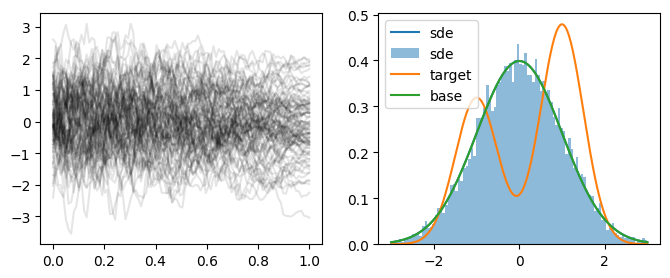

In [294]:
plt.figure(figsize=(8,3))
plt.subplot(121)
for i in range(100):
    plt.plot(ts[i], xs[i], 'k', alpha=0.1);

plt.subplot(122)
plt.plot(xlin, jnp.exp(logplin), 'C0', label="sde");
plt.hist(xs[:,-1], 100, range=xlim, density=True, alpha=0.5, label="sde");
plt.plot(xlin, target.prob(xlin), label="target");
plt.plot(xlin, base.prob(xlin), label="base");
plt.legend();

## 3 Loss and training
* Most of the approches rely on estimating $v_t$ or $\nabla\log \pp_t$ via the identities:
	* $v_t(x_t) = \int v_{t \mid 1}(x_t \mid x_1)\ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{t\mid 1}(x_t \mid x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$
	* $\nabla \log \pp_t(x_t) = \int \nabla \log \pp_{1}(x_1) \ \pp_{1 \mid t}(x_1 \mid x_t)\ \dd x_1$    for additive noise
* Let us define the following losses:
	* $\cL_\mathrm{FM}(\theta) := \EE_{t, x_t}[\norm{v_t^{\theta}(x_t) - v_t(x_t)}^2]$
	* $\cL_\mathrm{DFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - v_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TFM}(\theta) := \EE_{t, x_t, x_1}[\norm{v_t^{\theta}(x_t) - \alpha_t^{-1} v_{1}(x_1)}^2]$==?????==
	* $\cL_\mathrm{SM}(\theta) := \EE_{t, x_t}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t}(x_t)}^2]$
	* $\cL_\mathrm{ISM}(\theta) := \EE_{t, x_t}[\frac 1 2\norm{s^{\theta}_t(x_t) }^2 + \nabla \cdot s^{\theta}_t(x_t) ]$
	* $\cL_\mathrm{DSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \nabla\log \pp_{t\mid 1}(x_t \mid x_1)}^2]$
	* $\cL_\mathrm{TSM}(\theta) := \EE_{t, x_t, x_1}[\norm{s^{\theta}_t(x_t) - \alpha_t^{-1} \nabla\log \pp_{t}(x_t)}^2]$    for additive noise [*source*](http://arxiv.org/abs/2402.08667)
	* $\cL_\mathrm{EM}(\theta) := \EE_{t, x_t, x_1}[\norm{u^{\theta}_t(x_t) +\log \pp_{1}(x_1)}^2]$    [*source*](https://arxiv.org/pdf/2409.09787)
* Then we have
	* $\nabla_\theta \cL_\mathrm{FM}(\theta) = \nabla_\theta \cL_\mathrm{DFM}(\theta)$ and their argmin on $v^\theta$ is $v$.
	* $\nabla_\theta \cL_\mathrm{SM}(\theta)= \nabla_\theta \cL_\mathrm{ISM} = \nabla_\theta \cL_\mathrm{DSM}(\theta) = \nabla_\theta \cL_\mathrm{TSM}(\theta)$ and their argmin on $s^\theta$ is $\nabla\log \pp$.

In [295]:
def loss_tsm(params, t, yt, s1, w1):
  return (w1[:,None] * (vmap(score.apply, in_axes=(None, 0, 0))(params, yt, t) - s1 / alpha(t))**2).mean()

def loss_dsm(params, t, yt, y1, w1):
  return (w1[:,None] * (vmap(score.apply, in_axes=(None, 0, 0))(params, yt, t) + (yt - alpha(t) * y1) / beta(t)**2)**2).mean()

import optax
# Define the optimizer
optimizer = optax.chain(
    optax.adam(
        learning_rate=1e-2
        ),
    optax.contrib.reduce_on_plateau(
        factor=0.5,
        patience=10,
        ),
    )
optim_state = optimizer.init(params)


# Define the training step
@jit
def train_step(params, optimizer_state, t, y, s, w):
    # loss, grads = value_and_grad(loss_tsm)(params, t, y, s, w)
    loss, grads = value_and_grad(loss_dsm)(params, t, y, s, w)
    updates, optimizer_state = optimizer.update(grads, optimizer_state, params, value=loss)
    params = optax.apply_updates(params, updates)
    return params, optimizer_state, loss

# Training loop
batch_size = 512
key = jr.key(0)
losses = []

(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
Epoch 0, Loss: 943857664000.0, lr scale: 1.0
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
Epoch 10, Loss: 949964505088.0, lr scale: 1.0
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (51200, 1)
(512, 100) (512, 1)
(51200,) (51200, 1) (5

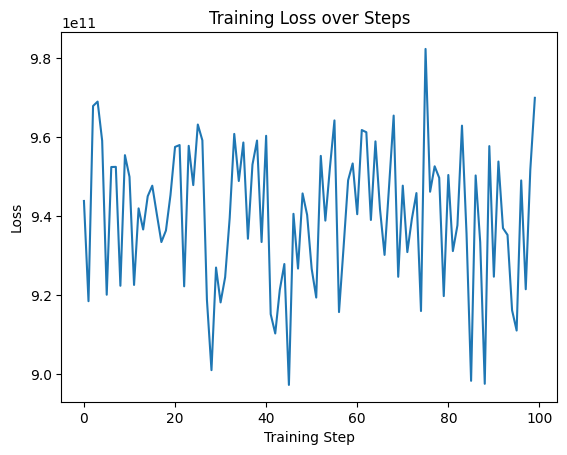

In [296]:
for epoch in range(100):
    key, key_samp, key_time, key_noise = jr.split(key, 4)

    # Sample a batch of trajectories
    ts, xs = sample_sde(jr.split(key_samp, batch_size), params)
    x1s = xs[:,-1] # (batch_size, dim)

    traj_length = int(1e2)
    eps = 1e-6
    ts = jnp.broadcast_to(jnp.linspace(eps, 1-eps ,traj_length), (batch_size, traj_length))
    x1s = target.sample(batch_size, key_samp) # (batch_size, dim)
    print(ts.shape, x1s.shape)

    # logps, scores = vmap(value_and_grad(target.log_prob))(x1s)
    # ws = logps - logp_sde(params, x1s) # (batch_size,)
    # ws = jnp.exp(ws - jnp.max(ws))
    # ws = ws / jnp.sum(ws)

    # ts = jr.uniform(key_time, batch_size)

    # scores = jnp.broadcast_to(scores[:,None], (*ts.shape, d)) # (batch_size, traj_length, dim)
    x1s = jnp.broadcast_to(x1s[:,None], (*ts.shape, d)) # (batch_size, traj_length, dim)
    # ws = jnp.broadcast_to(ws[:,None], ts.shape) # (batch_size, traj_length)
    scores = scores.reshape(-1, d)
    x1s = x1s.reshape(-1, d)
    # ws = ws.reshape(-1)
    ts = ts.reshape(-1)

    # Compute the score and loss
    xts = vmap(noise)(jr.split(key_noise, ts.shape), ts, x1s)
    print(ts.shape, x1s.shape, xts.shape)
    # params, optim_state, loss = train_step(params, optim_state, ts, xts, scores, ws)
    # params, optim_state, loss = train_step(params, optim_state, ts, xts, x1s, ws)
    params, optim_state, loss = train_step(params, optim_state, ts, xts, x1s, jnp.ones(1))
    losses.append(loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}, lr scale: {optax.tree.get(optim_state, 'scale')}")

# Plot the training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.show()

In [297]:
# Let's sample from the untrained process
ts, xs = sample_sde(jr.split(jr.key(0), 1000), params)
logplin = logp_sde(params, xlin)
print(ts.shape, xs.shape, logplin.shape)

(1000, 100) (1000, 100, 1) (256,)


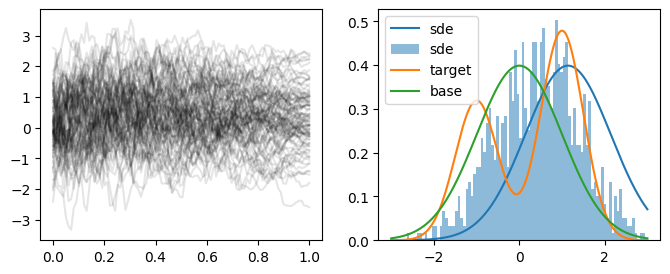

In [298]:
plt.figure(figsize=(8,3))
plt.subplot(121)
for i in range(100):
    plt.plot(ts[i], xs[i], 'k', alpha=0.1);

plt.subplot(122)
plt.plot(xlin, jnp.exp(logplin), 'C0', label="sde");
plt.hist(xs[:,-1], 100, range=xlim, density=True, alpha=0.5, label="sde");
plt.plot(xlin, target.prob(xlin), label="target");
plt.plot(xlin, base.prob(xlin), label="base");
plt.legend();